---
### Decision Trees

---


## Introduction

This lab explores decision tree classification, a powerful machine learning technique for making data-driven decisions. You will learn to build, visualize, and evaluate decision trees using a real-world dataset. The dataset used in this lab is that of Drug prediction based on the health parameters of a patient.


In [17]:
import numpy as np 
import pandas as pd

from matplotlib import pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn import metrics

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

### About the dataset
Imagine that you are a medical researcher compiling data for a study. You have collected data about a set of patients, all of whom suffered from the same illness. During their course of treatment, each patient responded to one of 5 medications, Drug A, Drug B, Drug C, Drug X and Drug Y. 

Part of your job is to build a model to find out which drug might be appropriate for a future patient with the same illness. The features of this dataset are the Age, Sex, Blood Pressure, and Cholesterol of the patients, and the target is the drug that each patient responded to.

It is a sample of a multiclass classifier, and you can use the training part of the dataset to build a decision tree, and then use it to predict the class of an unknown patient or to prescribe a drug to a new patient.


In [18]:
path= 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/Module%203/data/drug200.csv'
my_data = pd.read_csv(path)
my_data.sample(5)

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
15,16,F,HIGH,NORMAL,15.516,drugY
180,22,F,HIGH,NORMAL,22.818,drugY
48,23,M,NORMAL,HIGH,31.686,drugY
132,49,M,LOW,NORMAL,13.598,drugX
173,41,F,LOW,NORMAL,18.739,drugY


---
### Data Analysis and pre-processing

---
You should apply some basic analytics steps to understand the data better. First, let us gather some basic information about the dataset. 


In [19]:
my_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          200 non-null    int64  
 1   Sex          200 non-null    object 
 2   BP           200 non-null    object 
 3   Cholesterol  200 non-null    object 
 4   Na_to_K      200 non-null    float64
 5   Drug         200 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 9.5+ KB


This tells us that 4 out of the 6 features of this dataset are categorical, which will have to be converted into numerical ones to be used for modeling. For this, we can make use of __LabelEncoder__ from the Scikit-Learn library.


In [20]:
label_encoder = LabelEncoder()

my_data['Sex'] = label_encoder.fit_transform(my_data['Sex']) # deberia ser one hot para sex, ya que no tiene orden
my_data['BP'] = label_encoder.fit_transform(my_data['BP'])
my_data['Cholesterol'] = label_encoder.fit_transform(my_data['Cholesterol']) 
my_data

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,0,0,0,25.355,drugY
1,47,1,1,0,13.093,drugC
2,47,1,1,0,10.114,drugC
3,28,0,2,0,7.798,drugX
4,61,0,1,0,18.043,drugY
...,...,...,...,...,...,...
195,56,0,1,0,11.567,drugC
196,16,1,1,0,12.006,drugC
197,52,1,2,0,9.894,drugX
198,23,1,2,1,14.020,drugX


With this, you now have 5 parameters that can be used for modeling and 1 feature as the target variable. 
We can see from comparison of the data before Label encoding and after it, to note the following mapping.
<br>
- For parameter 'Sex' : $M \rightarrow 1, F \rightarrow 0$ <br>
- For parameter 'BP' : $High \rightarrow 0, Low \rightarrow 1, Normal \rightarrow 2$<br>
- For parameter 'Cholesterol' : $High \rightarrow 0, Normal \rightarrow 1$


You can also check if there are any missing values in the dataset. 


In [21]:
my_data.isnull().sum()

Age            0
Sex            0
BP             0
Cholesterol    0
Na_to_K        0
Drug           0
dtype: int64

This tells us that there are no missing values in any of the fields.


To evaluate the correlation of the target variable with the input features, it will be convenient to map the different drugs to a numerical value. Execute the following cell to achieve the same.


In [22]:
custom_map = {'drugA':0,'drugB':1,'drugC':2,'drugX':3,'drugY':4}
my_data['Drug_num'] = my_data['Drug'].map(custom_map)
my_data

,Age,Sex,BP,Cholesterol,Na_to_K,Drug,Drug_num
0,23,0,0,0,25.355,drugY,4
1,47,1,1,0,13.093,drugC,2
2,47,1,1,0,10.114,drugC,2
3,28,0,2,0,7.798,drugX,3
4,61,0,1,0,18.043,drugY,4
...,...,...,...,...,...,...,...
195,56,0,1,0,11.567,drugC,2
196,16,1,1,0,12.006,drugC,2
197,52,1,2,0,9.894,drugX,3
198,23,1,2,1,14.020,drugX,3


You can now use the __corr()__ function to find the correlation of the input variables with the target variable.

#### Practice question
Write the code to find the correlation of the input variables with the target variable and identify the features most significantly affecting the target.


In [23]:
my_data.drop("Drug", axis=1).corr()["Drug_num"]

Age           -0.004828
Sex           -0.098573
BP             0.372868
Cholesterol    0.055629
Na_to_K        0.589120
Drug_num       1.000000
Name: Drug_num, dtype: float64

This shows that the drug recommendation is mostly correlated with the `Na_to_K` and `BP` features. 


We can also understand the distribution of the dataset by plotting the count of the records with each drug recommendation. 


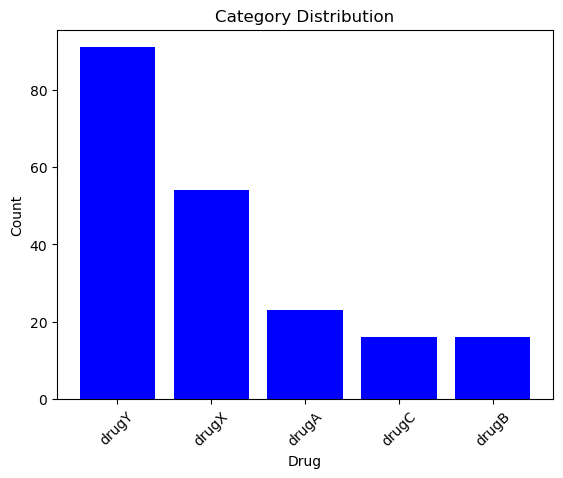

In [24]:
category_counts = my_data['Drug'].value_counts()

# Plot the count plot
plt.bar(category_counts.index, category_counts.values, color='blue')
plt.xlabel('Drug')
plt.ylabel('Count')
plt.title('Category Distribution')
plt.xticks(rotation=45)  # Rotate labels for better readability if needed
plt.show()

This shows us the distribution of the different classes, clearly indicating that Drug X and Drug Y have many more records in comparison to the other 3.


## Modeling


For modeling this dataset with a Decision tree classifier, we first split the dataset into training and testing subsets. For this, we separate the target variable from the input variables.


In [34]:
y = my_data['Drug']
X = my_data.drop(['Drug','Drug_num'], axis=1)
X

,Age,Sex,BP,Cholesterol,Na_to_K
0,23,0,0,0,25.355
1,47,1,1,0,13.093
2,47,1,1,0,10.114
3,28,0,2,0,7.798
4,61,0,1,0,18.043
...,...,...,...,...,...
195,56,0,1,0,11.567
196,16,1,1,0,12.006
197,52,1,2,0,9.894
198,23,1,2,1,14.020


Now, use the __train_test_split()__ function to separate the training data from the testing data. We can make use of 30% of the data for testing and the rest for training the Decision tree.


In [26]:
X_trainset, X_testset, y_trainset, y_testset = train_test_split(X, y, test_size=0.3, random_state=32)

You can now define the Decision tree classifier as __drugTree__ and train it with the training data. 


In [27]:
drugTree = DecisionTreeClassifier(criterion="entropy", max_depth = 4)

In [28]:
drugTree.fit(X_trainset,y_trainset)

,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.",'entropy'
,"splitter splitter: {""best"", ""random""}, default=""best""The strategy used to choose the split at each node. Supportedstrategies are ""best"" to choose the best split and ""random"" to choosethe best random split.",'best'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",4
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: int, float or {""sqrt"", ""log2""}, default=NoneThe number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... note:: The search for a split does not stop until at least one valid partition of the node samples is found, even if it requires to effectively inspect more than ``max_features`` features.",None
,"random_state random_state: int, RandomState instance or None, default=NoneControls the randomness of the estimator. The features are alwaysrandomly permuted at each split, even if ``splitter`` is set to``""best""``. When ``max_features < n_features``, the algorithm willselect ``max_features`` at random at each split before finding the bestsplit among them. But the best found split may vary across differentruns, even if ``max_features=n_features``. That is the case, if theimprovement of the criterion is identical for several splits and onesplit has to be selected at random. To obtain a deterministic behaviourduring fitting, ``random_state`` has to be fixed to an integer.See :term:`Glossary ` for details.",None
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow a tree with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the curre

### Evaluation


Now that you have trained the decision tree, we can use it to generate the predictions on the test set.


In [29]:
tree_predictions = drugTree.predict(X_testset)

We can now check the accuracy of our model by using the accuracy metric.


In [30]:
print("Decision Trees's Accuracy: ", metrics.accuracy_score(y_testset, tree_predictions))

Decision Trees's Accuracy:  0.9833333333333333


This means that the model was able to correctly identify the labels of 98.33%, i.e. 59 out of 60 test samples. 


### Visualize the tree

To understand the classification criteria derived by the Decision Tree, we may generate the tree plot.


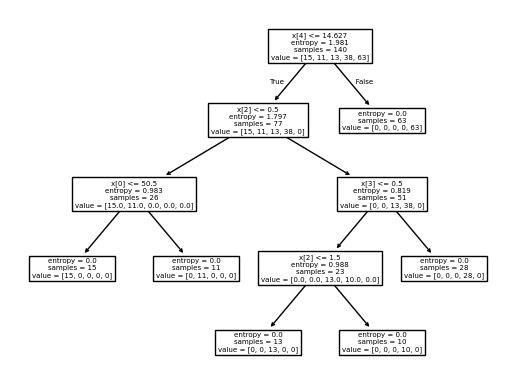

In [31]:
plot_tree(drugTree)
plt.show()

From this tree, we can derive the criteria developed by the model to identify the class of each training sample. We can interpret them by tracing the criteria defined by tracing down from the root to the tree's leaf nodes.

- For instance, the decision criterion for Drug Y is ${Na\_to\_K} \gt 14.627$.

#### Practice Question:
Along similar lines, identify the decision criteria for all other classes.


Drug A : $Na\_to\_K <= 14.627,\ BP = High,\ Age <= 50.5$<br>
Drug B : $Na\_to\_K <= 14.627,\ BP = High,\ Age > 50.5$<br>
Drug C : $Na\_to\_K <= 14.627,\ BP = Low,\ Cholesterol <= High$<br>
Drug X : $Na\_to\_K <= 14.627,\ BP = Normal,\ Cholesterol = High$

#### Practice Question:

If the max depth of the tree is reduced to 3, how would the performance of the model be affected?


In [36]:
drugTree = DecisionTreeClassifier(criterion="entropy", max_depth = 3)
drugTree.fit(X_trainset,y_trainset)
tree_predictions = drugTree.predict(X_testset)
print("Decision Trees's Accuracy: ", metrics.accuracy_score(y_testset, tree_predictions))

Decision Trees's Accuracy:  0.8166666666666667
